In [1]:
from google.colab import drive
import pandas as pd

# This will prompt for authorization to access your Google Drive
drive.mount('/content/drive')

# Update the file path to the location where you uploaded your CSV in Google Drive
file_path = '/content/drive/My Drive/Thesis/df-BERT.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Drop the first column (if it's an unwanted index column)
df = df.drop(df.columns[0], axis=1)

# Display the column names
df.columns.tolist()


Mounted at /content/drive


['price',
 'address',
 'descrip',
 'listed_since',
 'zip_code',
 'size',
 'year',
 'living_area',
 'kind_of_house',
 'building_type',
 'num_of_rooms',
 'num_of_bathrooms',
 'layout',
 'energy_label',
 'insulation',
 'heating',
 'ownership',
 'exteriors',
 'parking',
 'date_list',
 'last_ask_price',
 'last_ask_price_m2',
 'city',
 'log_id',
 'num of tokens per descrip',
 'descrip_en',
 'numerical_price',
 'numerical_price_per_m2',
 'tag',
 'house_category',
 'living_area_float',
 'size_float',
 'zip_code_4_digits',
 'postcode',
 'latitude',
 'longitude',
 'embeddings']

In [2]:
# Assuming df is your original DataFrame
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval


# Convert the 'ada_embedding_eng' column to a list of arrays if they are not already
df["embeddings"] = df["embeddings"].apply(literal_eval).apply(np.array)

x = df["embeddings"]
y = df['numerical_price']


###### deleting original dataframe for memory purpose ####
del df

In [3]:
x = x.apply(pd.Series)

# First split: separate out a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]

In [4]:

!pip install optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_nn(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.01, log=False)
    neurons_layer_1 = trial.suggest_int("neurons_layer_1", 16, 1024, step=16)
    neurons_layer_2 = trial.suggest_int("neurons_layer_2", 16, 512, step=16)
    neurons_layer_3 = trial.suggest_int("neurons_layer_3", 16, 256, step=16)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    epochs = trial.suggest_int("epochs", 5, 100)
    regularization = trial.suggest_categorical("regularization", ["none", "l1", "l2", "l1_l2"])
    l1_reg = trial.suggest_float("l1_reg", 1e-5, 1e-1, log=True) if regularization in ["l1", "l1_l2"] else 0
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-1, log=True) if regularization in ["l2", "l1_l2"] else 0

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]



        # Build model
        model = Sequential()
        model.add(Dense(neurons_layer_1, activation='relu', input_shape=(X_train_fold.shape[1],),
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_2, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_3, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(1, activation='linear'))

        # Compile model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Scaling y_train
        scaler = StandardScaler()
        y_train_scaled = scaler.fit_transform(y_train_fold.reshape(-1, 1)).flatten()

        # Train model
        model.fit(X_train_fold, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict and evaluate
        y_pred_scaled = model.predict(X_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)

    return np.mean(r2_scores)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.7 MB/s eta 0:00:00


In [5]:
import numpy as np

# Convert x_train and x_test to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)


print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


print("Adjusted y_train shape:", y_train.shape)
print("Adjusted y_test shape:", y_test.shape)


x_train shape: (10000, 768)
x_test shape: (14403, 768)
y_train shape: (10000,)
y_test shape: (14403,)
Adjusted y_train shape: (10000,)
Adjusted y_test shape: (14403,)


In [6]:
study_svr = optuna.create_study(directions=['maximize'])
study_svr.optimize(Objective_nn, n_trials=50)

[I 2024-01-07 09:29:24,742] A new study created in memory with name: no-name-e4bca0de-2ded-4aa1-96d2-a63a3dcef6aa


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 09:48:14,080] Trial 0 finished with value: 0.17230871467793446 and parameters: {'learning_rate': 0.006410519719590453, 'neurons_layer_1': 576, 'neurons_layer_2': 496, 'neurons_layer_3': 128, 'batch_size': 32, 'epochs': 100, 'regularization': 'none'}. Best is trial 0 with value: 0.17230871467793446.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 09:53:40,347] Trial 1 finished with value: -0.0011144915670725287 and parameters: {'learning_rate': 0.00603420825876952, 'neurons_layer_1': 944, 'neurons_layer_2': 96, 'neurons_layer_3': 240, 'batch_size': 32, 'epochs': 25, 'regularization': 'l1', 'l1_reg': 0.0010427509208568132}. Best is trial 0 with value: 0.17230871467793446.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 10:01:28,237] Trial 2 finished with value: -0.001251833300105387 and parameters: {'learning_rate': 0.007699167338210414, 'neurons_layer_1': 800, 'neurons_layer_2': 368, 'neurons_layer_3': 16, 'batch_size': 64, 'epochs': 56, 'regularization': 'l2', 'l2_reg': 0.02246508747421508}. Best is trial 0 with value: 0.17230871467793446.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 10:04:07,699] Trial 3 finished with value: -0.00361699480867963 and parameters: {'learning_rate': 0.0077970346932326635, 'neurons_layer_1': 112, 'neurons_layer_2': 240, 'neurons_layer_3': 144, 'batch_size': 16, 'epochs': 17, 'regularization': 'l2', 'l2_reg': 1.1187505556931501e-05}. Best is trial 0 with value: 0.17230871467793446.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-07 10:18:00,067] Trial 4 finished with value: -0.0010187407621613965 and parameters: {'learning_rate': 0.00205718903973304, 'neurons_layer_1': 624, 'neurons_layer_2': 272, 'neurons_layer_3': 240, 'batch_size': 32, 'epochs': 79, 'regularization': 'l2', 'l2_reg': 0.04020637274195791}. Best is trial 0 with value: 0.17230871467793446.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-07 10:32:06,290] Trial 5 finished with value: 0.29646830660118234 and parameters: {'learning_rate': 0.0011206870096408714, 'neurons_layer_1': 1024, 'neurons_layer_2': 368, 'neurons_layer_3': 192, 'batch_size': 128, 'epochs': 95, 'regularization': 'l2', 'l2_reg': 2.5760622657514667e-05}. Best is trial 5 with value: 0.29646830660118234.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 11:00:29,052] Trial 6 finished with value: 0.05876529158206347 and parameters: {'learning_rate': 0.0016787743112210032, 'neurons_layer_1': 848, 'neurons_layer_2': 96, 'neurons_layer_3': 192, 'batch_size': 16, 'epochs': 95, 'regularization': 'l2', 'l2_reg': 0.00039298273170939696}. Best is trial 5 with value: 0.29646830660118234.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 11:17:04,380] Trial 7 finished with value: 0.23829880606481896 and parameters: {'learning_rate': 0.001662735608497661, 'neurons_layer_1': 832, 'neurons_layer_2': 288, 'neurons_layer_3': 224, 'batch_size': 32, 'epochs': 73, 'regularization': 'l2', 'l2_reg': 0.0009536415929199143}. Best is trial 5 with value: 0.29646830660118234.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 11:25:48,686] Trial 8 finished with value: -0.0035467940115095687 and parameters: {'learning_rate': 0.004613392804220472, 'neurons_layer_1': 384, 'neurons_layer_2': 112, 'neurons_layer_3': 96, 'batch_size': 16, 'epochs': 45, 'regularization': 'l1_l2', 'l1_reg': 0.005616364616798994, 'l2_reg': 0.0005764948954015442}. Best is trial 5 with value: 0.29646830660118234.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 11:31:42,161] Trial 9 finished with value: -0.0020435630398977 and parameters: {'learning_rate': 0.007440575642427498, 'neurons_layer_1': 576, 'neurons_layer_2': 96, 'neurons_layer_3': 224, 'batch_size': 64, 'epochs': 72, 'regularization': 'l1', 'l1_reg': 0.0009990192634316212}. Best is trial 5 with value: 0.29646830660118234.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:33:45,120] Trial 10 finished with value: 0.34905287884566 and parameters: {'learning_rate': 0.00027340274374626527, 'neurons_layer_1': 336, 'neurons_layer_2': 512, 'neurons_layer_3': 64, 'batch_size': 128, 'epochs': 39, 'regularization': 'none'}. Best is trial 10 with value: 0.34905287884566.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:35:24,079] Trial 11 finished with value: 0.36859788248023906 and parameters: {'learning_rate': 0.00011537517874580153, 'neurons_layer_1': 240, 'neurons_layer_2': 512, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 40, 'regularization': 'none'}. Best is trial 11 with value: 0.36859788248023906.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:36:51,306] Trial 12 finished with value: 0.35361000370843865 and parameters: {'learning_rate': 0.00019857674785979867, 'neurons_layer_1': 224, 'neurons_layer_2': 512, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 37, 'regularization': 'none'}. Best is trial 11 with value: 0.36859788248023906.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:37:39,623] Trial 13 finished with value: 0.05522272303506433 and parameters: {'learning_rate': 0.0036258546436609314, 'neurons_layer_1': 64, 'neurons_layer_2': 432, 'neurons_layer_3': 16, 'batch_size': 128, 'epochs': 32, 'regularization': 'none'}. Best is trial 11 with value: 0.36859788248023906.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 11:38:10,619] Trial 14 finished with value: 0.136612422507443 and parameters: {'learning_rate': 0.009654518116943445, 'neurons_layer_1': 240, 'neurons_layer_2': 448, 'neurons_layer_3': 64, 'batch_size': 128, 'epochs': 11, 'regularization': 'none'}. Best is trial 11 with value: 0.36859788248023906.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:40:18,260] Trial 15 finished with value: 0.3813594637670847 and parameters: {'learning_rate': 0.00013189685881053736, 'neurons_layer_1': 240, 'neurons_layer_2': 384, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 57, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:43:43,878] Trial 16 finished with value: 0.1368248403908663 and parameters: {'learning_rate': 0.0030762338116188757, 'neurons_layer_1': 400, 'neurons_layer_2': 384, 'neurons_layer_3': 64, 'batch_size': 128, 'epochs': 57, 'regularization': 'l1_l2', 'l1_reg': 1.9169787270498788e-05, 'l2_reg': 0.006520027129134498}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:45:24,754] Trial 17 finished with value: 0.3158249832374114 and parameters: {'learning_rate': 0.0026987542981345746, 'neurons_layer_1': 160, 'neurons_layer_2': 208, 'neurons_layer_3': 112, 'batch_size': 128, 'epochs': 64, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:48:15,957] Trial 18 finished with value: 0.2778357912818319 and parameters: {'learning_rate': 0.004070300877416074, 'neurons_layer_1': 448, 'neurons_layer_2': 448, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 48, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-07 11:48:58,239] Trial 19 finished with value: 0.12411967175666978 and parameters: {'learning_rate': 0.0007269690255291278, 'neurons_layer_1': 16, 'neurons_layer_2': 336, 'neurons_layer_3': 96, 'batch_size': 64, 'epochs': 23, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:49:16,743] Trial 20 finished with value: -0.0009039636845746379 and parameters: {'learning_rate': 0.002446094594774054, 'neurons_layer_1': 288, 'neurons_layer_2': 192, 'neurons_layer_3': 160, 'batch_size': 128, 'epochs': 5, 'regularization': 'l1_l2', 'l1_reg': 0.055308068816184594, 'l2_reg': 9.305440145526971e-05}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 11:50:41,194] Trial 21 finished with value: 0.3620541350745065 and parameters: {'learning_rate': 0.0001241607111442255, 'neurons_layer_1': 224, 'neurons_layer_2': 480, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 35, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 11:51:39,457] Trial 22 finished with value: 0.19703307115742769 and parameters: {'learning_rate': 0.0009977278822627532, 'neurons_layer_1': 160, 'neurons_layer_2': 416, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 31, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:54:38,781] Trial 23 finished with value: 0.3523572523419314 and parameters: {'learning_rate': 0.00011935987018720857, 'neurons_layer_1': 480, 'neurons_layer_2': 464, 'neurons_layer_3': 80, 'batch_size': 128, 'epochs': 45, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:57:03,024] Trial 24 finished with value: 0.21743811528384166 and parameters: {'learning_rate': 0.0010779829249592794, 'neurons_layer_1': 272, 'neurons_layer_2': 320, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 62, 'regularization': 'l1', 'l1_reg': 1.6693228049787815e-05}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:58:39,037] Trial 25 finished with value: 0.12587905136893915 and parameters: {'learning_rate': 0.001694066452363167, 'neurons_layer_1': 176, 'neurons_layer_2': 480, 'neurons_layer_3': 16, 'batch_size': 128, 'epochs': 52, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:00:25,488] Trial 26 finished with value: 0.2979777851326191 and parameters: {'learning_rate': 0.003097917462528978, 'neurons_layer_1': 320, 'neurons_layer_2': 400, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 40, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-07 12:01:18,995] Trial 27 finished with value: 0.055150918203603204 and parameters: {'learning_rate': 0.0008699055510725858, 'neurons_layer_1': 16, 'neurons_layer_2': 480, 'neurons_layer_3': 80, 'batch_size': 64, 'epochs': 27, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-07 12:06:05,686] Trial 28 finished with value: 0.11472091105413243 and parameters: {'learning_rate': 0.002194422974459359, 'neurons_layer_1': 688, 'neurons_layer_2': 336, 'neurons_layer_3': 32, 'batch_size': 16, 'epochs': 17, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:16:46,638] Trial 29 finished with value: 0.14374159811553916 and parameters: {'learning_rate': 0.009873087518545362, 'neurons_layer_1': 528, 'neurons_layer_2': 512, 'neurons_layer_3': 128, 'batch_size': 32, 'epochs': 66, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-07 12:18:22,246] Trial 30 finished with value: 0.0241989870787098 and parameters: {'learning_rate': 0.005751193346752367, 'neurons_layer_1': 96, 'neurons_layer_2': 16, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 85, 'regularization': 'l1', 'l1_reg': 0.00018717710762729625}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:19:45,028] Trial 31 finished with value: 0.31059164034059866 and parameters: {'learning_rate': 0.00032269079094685433, 'neurons_layer_1': 224, 'neurons_layer_2': 512, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 36, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 12:21:28,485] Trial 32 finished with value: 0.2751617595714434 and parameters: {'learning_rate': 0.00038873411906570874, 'neurons_layer_1': 208, 'neurons_layer_2': 480, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 50, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:23:31,384] Trial 33 finished with value: 0.08109250991845489 and parameters: {'learning_rate': 0.0015133849022814626, 'neurons_layer_1': 384, 'neurons_layer_2': 416, 'neurons_layer_3': 16, 'batch_size': 128, 'epochs': 42, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:24:23,571] Trial 34 finished with value: 0.3660519570017707 and parameters: {'learning_rate': 0.00014483759776619346, 'neurons_layer_1': 112, 'neurons_layer_2': 448, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 35, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:26:06,459] Trial 35 finished with value: -0.0008744439299163797 and parameters: {'learning_rate': 0.001270008706032071, 'neurons_layer_1': 112, 'neurons_layer_2': 448, 'neurons_layer_3': 80, 'batch_size': 32, 'epochs': 22, 'regularization': 'l1_l2', 'l1_reg': 0.04347486490026706, 'l2_reg': 0.00630221334914016}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:28:24,129] Trial 36 finished with value: 0.29169668037196744 and parameters: {'learning_rate': 0.0007095568508540479, 'neurons_layer_1': 128, 'neurons_layer_2': 368, 'neurons_layer_3': 48, 'batch_size': 64, 'epochs': 59, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:34:09,172] Trial 37 finished with value: -0.001283410334485069 and parameters: {'learning_rate': 0.002057518566182464, 'neurons_layer_1': 320, 'neurons_layer_2': 400, 'neurons_layer_3': 64, 'batch_size': 16, 'epochs': 29, 'regularization': 'l1', 'l1_reg': 0.00011910349186557853}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:35:24,705] Trial 38 finished with value: -0.0009293842085048798 and parameters: {'learning_rate': 0.005172370632059914, 'neurons_layer_1': 48, 'neurons_layer_2': 480, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 54, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:41:29,679] Trial 39 finished with value: -0.000924001303910682 and parameters: {'learning_rate': 0.00648942257300825, 'neurons_layer_1': 688, 'neurons_layer_2': 368, 'neurons_layer_3': 112, 'batch_size': 32, 'epochs': 33, 'regularization': 'l2', 'l2_reg': 0.08235718413590194}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:42:11,491] Trial 40 finished with value: 0.08478711385841127 and parameters: {'learning_rate': 0.00897612801548241, 'neurons_layer_1': 272, 'neurons_layer_2': 304, 'neurons_layer_3': 16, 'batch_size': 128, 'epochs': 18, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:43:29,497] Trial 41 finished with value: 0.35004026493106377 and parameters: {'learning_rate': 0.00014399284775590867, 'neurons_layer_1': 208, 'neurons_layer_2': 496, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 37, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:44:55,103] Trial 42 finished with value: 0.23840604674223656 and parameters: {'learning_rate': 0.0006935139140130332, 'neurons_layer_1': 160, 'neurons_layer_2': 512, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 43, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:47:10,018] Trial 43 finished with value: 0.19187359347126118 and parameters: {'learning_rate': 0.0014439669939842416, 'neurons_layer_1': 352, 'neurons_layer_2': 432, 'neurons_layer_3': 64, 'batch_size': 128, 'epochs': 47, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:48:02,319] Trial 44 finished with value: 0.3461159677848108 and parameters: {'learning_rate': 0.0005517697888580405, 'neurons_layer_1': 80, 'neurons_layer_2': 464, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 34, 'regularization': 'l2', 'l2_reg': 0.00010798532612485973}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:52:24,709] Trial 45 finished with value: 0.3344044215176951 and parameters: {'learning_rate': 0.00011633534573455302, 'neurons_layer_1': 256, 'neurons_layer_2': 496, 'neurons_layer_3': 80, 'batch_size': 16, 'epochs': 25, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:54:17,806] Trial 46 finished with value: 0.2569997193120841 and parameters: {'learning_rate': 0.0017696515638973805, 'neurons_layer_1': 416, 'neurons_layer_2': 240, 'neurons_layer_3': 192, 'batch_size': 128, 'epochs': 39, 'regularization': 'none'}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:55:43,949] Trial 47 finished with value: -0.0008540548161573458 and parameters: {'learning_rate': 0.0011352938853132987, 'neurons_layer_1': 128, 'neurons_layer_2': 448, 'neurons_layer_3': 48, 'batch_size': 128, 'epochs': 50, 'regularization': 'l1_l2', 'l1_reg': 0.009796397315258554, 'l2_reg': 0.003233088076678859}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:58:31,218] Trial 48 finished with value: -0.0012699828205806618 and parameters: {'learning_rate': 0.0027892612221821233, 'neurons_layer_1': 208, 'neurons_layer_2': 416, 'neurons_layer_3': 16, 'batch_size': 64, 'epochs': 55, 'regularization': 'l1', 'l1_reg': 0.000162555693355344}. Best is trial 15 with value: 0.3813594637670847.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 13:06:23,599] Trial 49 finished with value: 0.27780302791873407 and parameters: {'learning_rate': 0.0006352288189158534, 'neurons_layer_1': 912, 'neurons_layer_2': 464, 'neurons_layer_3': 64, 'batch_size': 128, 'epochs': 71, 'regularization': 'l2', 'l2_reg': 8.78061062988445e-05}. Best is trial 15 with value: 0.3813594637670847.


<ipython-input-7-b7f3a9c196e1>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

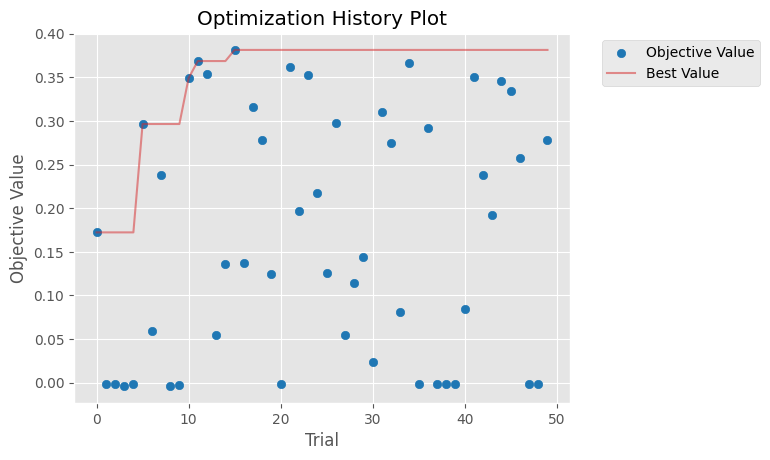

In [7]:
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

<ipython-input-8-62749383f84c>:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
<ipython-input-8-62749383f84c>:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
<ipython-input-8-62749383f84c>:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_svr)


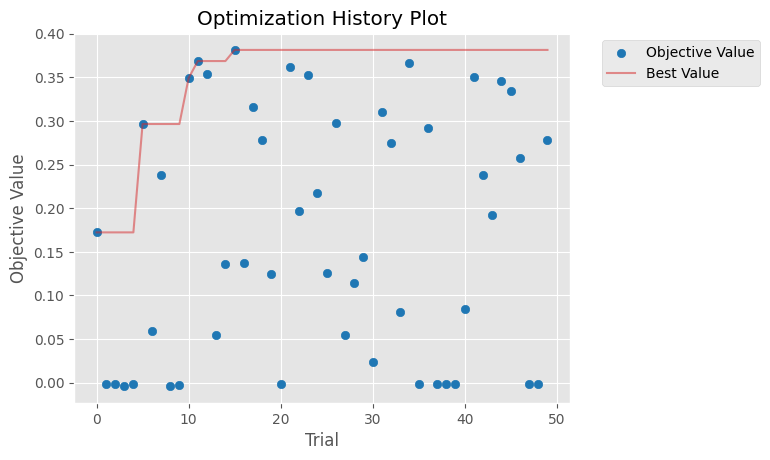

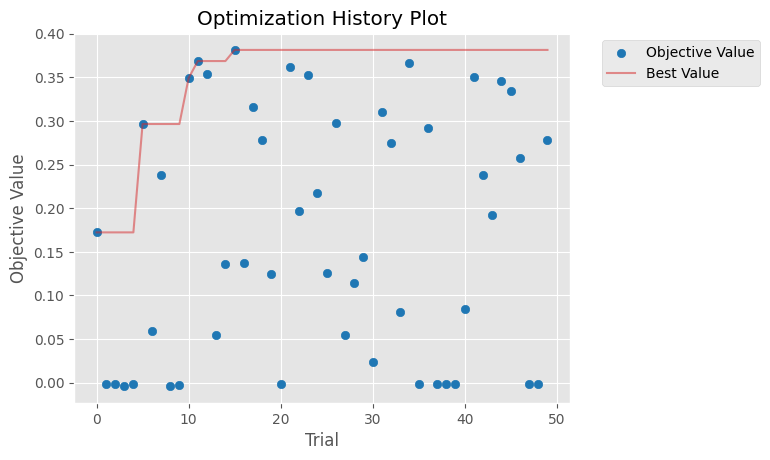

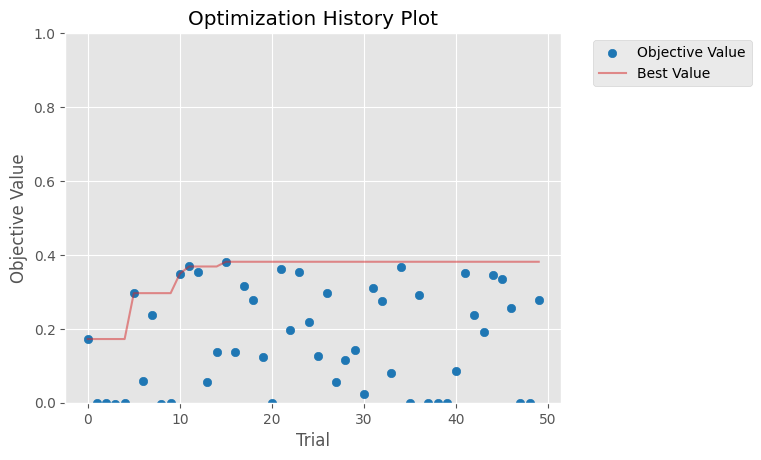

In [8]:
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

optuna.visualization.matplotlib.plot_optimization_history(study_svr)
optuna_matplotlib.plot_optimization_history(study_svr)

plt.ylim(0, 1)

# Show the plot
plt.show()